## Required Packages & Setup

In [ ]:
# This block handles some basic setup and data loading.  

## imports
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import tqdm
import random
import pdb
from itertools import permutations
import seaborn as sns

!pip install torchtext==0.10.0.
import torch
from torch import nn
import torch.nn.functional as F
import torchtext.legacy as torchtext

## download and load the data
text_field = torchtext.data.Field()
datasets = torchtext.datasets.WikiText2.splits(root='.', text_field=text_field)
train_dataset, validation_dataset, test_dataset = datasets
text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Installation of the GPT2 Model

In [ ]:
!pip install transformers
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 44.8 MB/s 


The following code downloads model weights and can take a few minutes to run. For debugging purposes, feel free to swap out `gpt2-large` with a smaller model that downloads faster. Note that predictions made by `gpt-medium` and `gpt-small` are trained with less samples, implying lower predictive power.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
    print("Running on GPU")
else:
    device = "cpu"
    print("Running on CPU")
    
model = GPT2LMHeadModel.from_pretrained("gpt2-large").to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2-large")

Running on GPU


Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
vocab_map = {}
vocab = tokenizer.vocab
for token in tqdm.tqdm(vocab):
    idx = vocab[token]
    vocab_map[idx] = token

100%|██████████| 50257/50257 [00:00<00:00, 1706923.76it/s]


In [ ]:
sentence = "<|endoftext|>This is an example sentence"
encodings = tokenizer(sentence, return_tensors='pt')
print(encodings["input_ids"])
print([vocab_map[int(idx)] for idx in encodings["input_ids"][0]])

tensor([[50256,  1212,   318,   281,  1672,  6827]])
['<|endoftext|>', 'This', 'Ġis', 'Ġan', 'Ġexample', 'Ġsentence']


In [ ]:
keys = ['good', 'bad', 'great','positive', 'negative']
[(tokenizer(word, return_tensors='pt')["input_ids"].item(),word) for word in keys]

[(11274, 'good'),
 (14774, 'bad'),
 (18223, 'great'),
 (24561, 'positive'),
 (31591, 'negative')]

## Sentiment Keyword Selection

Done through zero-shot tests on test dataset. 

Note: Comments provide sentiment-keyword pair under test.

In [ ]:
def predict_sentiment(prompt, sentence):
  prompt = prompt.format(sentence)
  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)
  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][14774] ; pos = probs[-1][11274]
  return 0 if neg > pos else 1

def accuracy(prompt,num_cases = 1000):
  num_correct = 0
  for idx in tqdm.tqdm(range(num_cases)):
    example = dataset["train"][idx]
    predicted_label = predict_sentiment(prompt, example["sentence"])
    if predicted_label == example["label"]:
      num_correct += 1
  print()
  print("Accuracy: {}".format(num_correct / num_cases))

In [ ]:
# zero-shot accuracy of (good,bad) sentiment tokens
def predict_sentiment(prompt, sentence):
  prompt = prompt.format(sentence)
  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)
  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][14774] ; pos = probs[-1][18223]
  return 0 if neg > pos else 1

accuracy("The sentiment of '{}' is ", 1000)

100%|██████████| 1000/1000 [00:36<00:00, 27.36it/s]


Accuracy: 0.57


In [ ]:
# zero-shot accuracy of (positive, negative) sentiment tokens
def predict_sentiment(prompt, sentence):
  prompt = prompt.format(sentence)
  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)
  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][31591] ; pos = probs[-1][24561]
  return 0 if neg > pos else 1

accuracy("The sentiment of '{}' is ", 1000)

100%|██████████| 1000/1000 [00:39<00:00, 25.23it/s]


Accuracy: 0.543


In [ ]:
# zero-shot accuracy of (great,bad) sentiment tokens
def predict_sentiment(prompt, sentence):
  prompt = prompt.format(sentence)
  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)
  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][14771] ; pos = probs[-1][11274]
  return 0 if neg > pos else 1

accuracy("The sentiment of '{}' is ", 1000)

100%|██████████| 1000/1000 [00:34<00:00, 29.07it/s]


Accuracy: 0.542


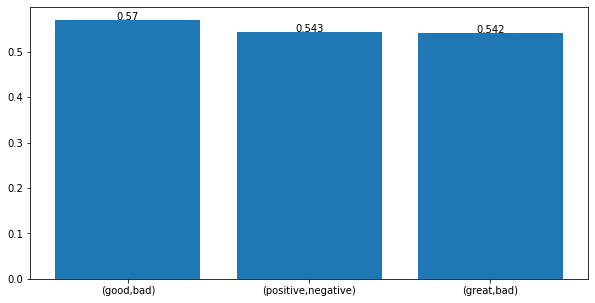

In [ ]:
# define accuracy scores & labels
y = [0.57,0.543,0.542]
x = ["(good,bad)", "(positive,negative)", "(great,bad)"]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.figure(figsize = (10, 5))
plt.bar(x, y)
addlabels(x, y)

### Prompting with Language Models

Language models can be coerced into performing a variety of different tasks via *prompting*, as shown in the [GPT-3 paper](https://arxiv.org/abs/2005.14165). At a high level, prompting involves putting a few training examples into the context of a model and then using next word prediction to predict labels. In this sextion, we'll use prompting and the GPT-2 Large model on the sentiment task SST-2. But first, we'll download the dataset:

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset["test"][20]

{'sentence': 'some , like ballistic , arrive stillborn ... looking like the beaten , well-worn video box cover of seven years into the future .',
 'label': -1,
 'idx': 20}

Now, it's time to write a prompt for sentiment prediction. Here's an example what a prompt might look like for the task of machine translation:


```
The French "Le Tea Party est atterré." in English is "The tea party is aghast"
The French "Cela est vraiment indispensable pour notre nation." in English is "This really is a must for our nation."
The French "Il va y avoir du changement dans la façon dont nous payons ces taxes." in English is "There is going to be a change in how we pay these taxes."
The French "La technologie est là pour le faire." in English is
```
The model would then predict the next tokens, hopefully resulting in an English translation of the final sentence. Note that these examples are all taken from the `wmt14` translation dataset. In our case, however, we'll be predicting sentiment, which is represented by a binary value in the Stanford Sentiment Treebank. To convert next-word predictions into a binary decision, we'll compute the probability of two words (e.g., "yes" vs. "no") and then choose our label based on whichever one has the highest probability. 

In [ ]:
def predict_sentiment(prompt,sentence):
  prompt = prompt.format(sentence)
  encodings = tokenizer(prompt, return_tensors='pt')
  test = encodings.input_ids.to(device)
  logits = model(test).logits.squeeze(0)
  probs = F.log_softmax(logits, dim = 1).squeeze(0)
  neg = probs[-1][14774] ; pos = probs[-1][11274]
  if neg > pos:
    return 0
  return 1

In [ ]:
prompt = "The sentiment of 'love and romance are integral parts of human nature' is good. \
            The sentiment of 'distressed widow living alone' is bad. The sentiment \
            of 'wonderful joyous refreshing days ahead' is good. The sentiment of 'sad \
            depressing nights' is bad. The sentiment of 'the broken glass \
            shattered onto the bloody floor' is bad. The sentiment of '{}' is "

In [ ]:
num_correct = 0
for idx in tqdm.tqdm(range(1000)):
  example = dataset["train"][idx]
  predicted_label = predict_sentiment(prompt,example["sentence"])
  if predicted_label == example["label"]:
    num_correct += 1
print()
print("Accuracy: {}".format(num_correct / 1000))

100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s]



Accuracy: 0.81


Our best performing model gets 85% accuracy on this task, and our template-only baseline (i.e., without any training examples in the context) gets 69%. There are numerous prompt formats that score above 70%, but I encourage you to try to beat my scores! Please be aware that prompting can lead to high variance results, and checkout the following paper for additional tips and details: https://arxiv.org/pdf/2102.09690.pdf

Are we cheating? How do we explain this difference between top-of-the-line model to something worse than guessing? Note that this variability of accuracy arises in not only the key-word we search for, but also in the order of the prompts, the distribution of the promps, and the number of prompts.